# Day-1

# Understand business problem
 # 1.Objective:
 Predict the next month’s product sales based on historical sales data.

Evaluate predictions using MAPE (Mean Absolute Percentage Error) and RMSE (Root Mean Squared Error).
# 2. Collect Dataset
In this step, we load the historical retail sales dataset.  
The dataset contains monthly sales data for different products over several years.  
We will use this data to analyze sales trends and forecast next month's sales.


<!-- Objective: -->

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller


In [36]:
# Modeling libraries
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from prophet import Prophet

In [37]:

# 1. Load All Data
df = pd.read_csv("Walmart.csv")

# 2. Convert Date
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# 3. Sort Data correctly (Store first, then Date)
# This is crucial so that Store 1's timeline is clean, then Store 2, etc.
df = df.sort_values(by=['Store', 'Date'])

# 4. Feature Engineering
df['month'] = df['Date'].dt.month
df['week_of_year'] = df['Date'].dt.isocalendar().week
df['year'] = df['Date'].dt.year

# --- CRITICAL CHANGE: GROUPBY LAGS ---
# We use .groupby('Store') so the shift doesn't mix data between different stores
df['Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['Lag_4'] = df.groupby('Store')['Weekly_Sales'].shift(4)

# Rolling Mean per Store
df['Rolling_Mean_4'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(window=4).mean())

# 5. Drop NaNs (First 4 weeks of every store will be empty because of lags)
df.dropna(inplace=True)

# 6. Reset Index for cleaner look
df.reset_index(drop=True, inplace=True)

print(f"Data Ready. Total Rows: {df.shape[0]}")
print(f"Stores included: {df['Store'].nunique()}")
df.head()

Data Ready. Total Rows: 6255
Stores included: 45


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,week_of_year,year,Lag_1,Lag_4,Rolling_Mean_4
0,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,9,2010,1409727.59,1643690.90,1.554615e+06
1,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,3,10,2010,1554806.68,1641957.44,1.504011e+06
2,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,3,11,2010,1439541.59,1611968.17,1.469148e+06
3,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,3,12,2010,1472515.79,1409727.59,1.467823e+06
4,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808,4,13,2010,1404429.92,1554806.68,1.477864e+06


# Day-2

In [38]:
# Step 1
df.isnull().sum()

Store             0
Date              0
Weekly_Sales      0
Holiday_Flag      0
Temperature       0
Fuel_Price        0
CPI               0
Unemployment      0
month             0
week_of_year      0
year              0
Lag_1             0
Lag_4             0
Rolling_Mean_4    0
dtype: int64

In [39]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'month', 'week_of_year', 'year',
       'Lag_1', 'Lag_4', 'Rolling_Mean_4'],
      dtype='object')

In [40]:
df = df.sort_values(["Store", "Date"])
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,week_of_year,year,Lag_1,Lag_4,Rolling_Mean_4
0,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,9,2010,1409727.59,1643690.90,1.554615e+06
1,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,3,10,2010,1554806.68,1641957.44,1.504011e+06
2,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,3,11,2010,1439541.59,1611968.17,1.469148e+06
3,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,3,12,2010,1472515.79,1409727.59,1.467823e+06
4,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808,4,13,2010,1404429.92,1554806.68,1.477864e+06


In [41]:
df['Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['Lag_2'] = df.groupby('Store')['Weekly_Sales'].shift(2)
df['Lag_3'] = df.groupby('Store')['Weekly_Sales'].shift(3)

df[['Lag_1','Lag_2','Lag_3']] = df[['Lag_1','Lag_2','Lag_3']].fillna(0)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,week_of_year,year,Lag_1,Lag_4,Rolling_Mean_4,Lag_2,Lag_3
0,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,9,2010,0.00,1643690.90,1.554615e+06,0.00,0.00
1,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,3,10,2010,1554806.68,1641957.44,1.504011e+06,0.00,0.00
2,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,3,11,2010,1439541.59,1611968.17,1.469148e+06,1554806.68,0.00
3,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,3,12,2010,1472515.79,1409727.59,1.467823e+06,1439541.59,1554806.68
4,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808,4,13,2010,1404429.92,1554806.68,1.477864e+06,1472515.79,1439541.59


# Day 3 – Modeling
### •	Build ARIMA, Prophet, XGBoost models
### •	Cross-validation


In [42]:
# ============================================================================
# DAY 3: LOAD AND PREPARE DATA (CORRECTED)
# ============================================================================
import pandas as pd
import numpy as np

print("="*60)
print("STEP 1: LOAD WALMART DATA")
print("="*60)

# 1. Load the dataset explicitly (No try/except limits)
# We assume you have the file from Day 2 logic. 
# If this fails, we WANT it to crash so you know the file is missing.
df = pd.read_csv('Walmart.csv')

# 2. Ensure Dates are parsed correctly
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
else:
    raise ValueError("Error: 'Date' column missing. Please check your CSV file.")

# 3. Sort by Store and Date (Crucial for Multi-Store Time Series)
df = df.sort_values(by=['Store', 'Date'])

# 4. Quick Feature Check
# We need to make sure your Day 2 engineering (Lags) is actually there.
required_features = ['Lag_1', 'Lag_4', 'Rolling_Mean_4']
missing_cols = [col for col in required_features if col not in df.columns]

if missing_cols:
    print(f"⚠️ WARNING: Missing engineered features: {missing_cols}")
    print("   Please re-run the Day 2 Data Engineering code block before proceeding.")
else:
    print("✓ All engineered features (Lags & Rolling Means) found.")

print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total Stores: {df['Store'].nunique()}")

print("\nData Overview (First 5 rows):")
display(df.head())

STEP 1: LOAD WALMART DATA
⚠️ WARNING: Missing engineered features: ['Lag_1', 'Lag_4', 'Rolling_Mean_4']
   Please re-run the Day 2 Data Engineering code block before proceeding.

Dataset shape: (6435, 8)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Total Stores: 45

Data Overview (First 5 rows):


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106



STEP 4: PREPARE FOR MODELING
Target: Weekly_Sales
Number of features: 6
Feature names: ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

Train set: 5148 samples
Test set:  1287 samples


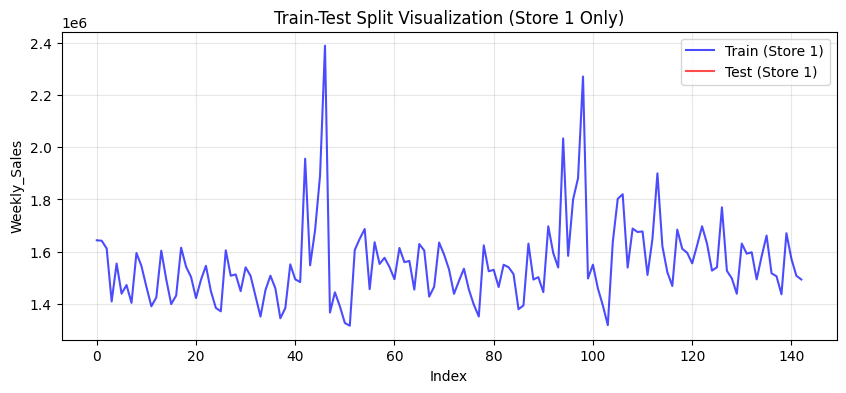

In [43]:
# ============================================================================
# STEP 4: PREPARE FOR MODELING
# ============================================================================
print("\n" + "="*60)
print("STEP 4: PREPARE FOR MODELING")
print("="*60)

# 1. Define your specific Target and Data
target_col = 'Weekly_Sales'  # <--- This was missing before
df_model = df.copy()         # <--- We work on a copy to be safe

# 2. Check and Split
if target_col and target_col in df_model.columns:
    
    # 3. Separate Target (y) and Features (X)
    y = df_model[target_col]
    
    # Drop columns that are not useful for training features
    # (We drop 'Date' because models need numbers, not timestamps)
    drop_cols = [target_col, 'Date'] 
    X = df_model.drop(columns=drop_cols, errors='ignore')
    
    print(f"Target: {target_col}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Feature names: {list(X.columns)}")
    
    # 4. Split Data (Time-based split for Time Series)
    # We take the first 80% as Train, last 20% as Test
    train_size = int(len(X) * 0.8)
    
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    print(f"\nTrain set: {X_train.shape[0]} samples")
    print(f"Test set:  {X_test.shape[0]} samples")
    
    # 5. Simple visualization of the split
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    # Plotting only the first store's data to keep the chart readable
    # (This is just for visualization, the model uses ALL data)
    subset_train = y_train[X_train['Store']==1]
    subset_test = y_test[X_test['Store']==1]
    
    plt.plot(subset_train.index, subset_train.values, 'b-', label='Train (Store 1)', alpha=0.7)
    plt.plot(subset_test.index, subset_test.values, 'r-', label='Test (Store 1)', alpha=0.7)
    plt.title(f'Train-Test Split Visualization (Store 1 Only)')
    plt.xlabel('Index')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
else:
    print(f"Error: Target column '{target_col}' not found in dataset!")

TRAINING XGBOOST MODEL
Training in progress...
[0]	validation_0-rmse:557511.82532	validation_1-rmse:512669.78609
[64]	validation_0-rmse:158340.37553	validation_1-rmse:520311.97997

------------------------------
FINAL RESULTS
------------------------------
RMSE: 440,255.78
MAPE: 61.61%
------------------------------
Stores in Test Set: [37 38 39 40 41 42 43 44 45]
Plotting results for Store: 37


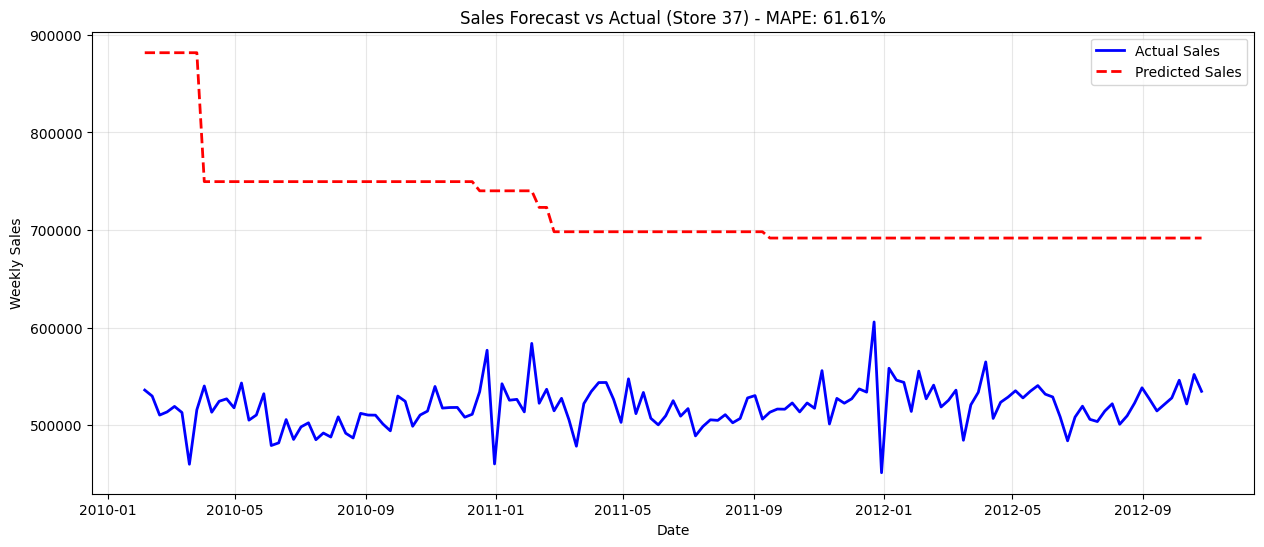

<Figure size 1000x500 with 0 Axes>

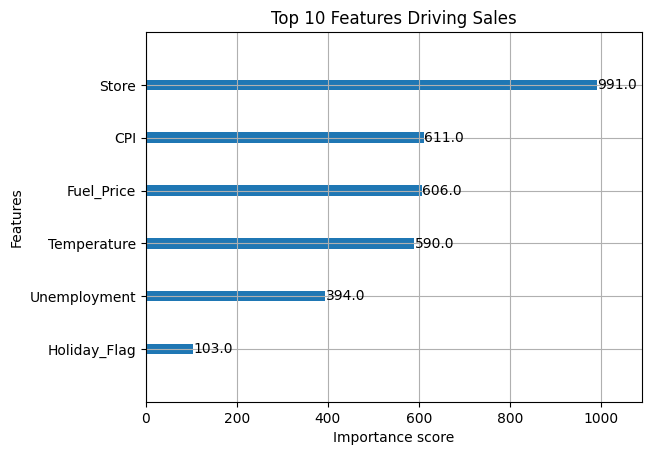

In [44]:
# ============================================================================
# STEP 5: TRAIN XGBOOST & EVALUATE 
# ============================================================================
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("TRAINING XGBOOST MODEL")
print("="*60)

# 1. Initialize the Model
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

# 2. Train (Fit) the Model
print("Training in progress...")
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100 
)

# 3. Predict on Test Set
preds = reg.predict(X_test)

# 4. Evaluate (RMSE & MAPE) - THIS IS THE PART YOU WERE MISSING
rmse = np.sqrt(mean_squared_error(y_test, preds))
mape = mean_absolute_percentage_error(y_test, preds)

print("\n" + "-"*30)
print("FINAL RESULTS")
print("-"*(30))
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2%}") # This will print percentage (e.g., 5.32%)
print("-"*(30))

# 5. Visualize Results (Corrected for Test Set Stores)
# A. Find which stores are actually in the Test Set
available_stores = X_test['Store'].unique()
print(f"Stores in Test Set: {available_stores}")

# B. Pick the first one found
store_id = available_stores[0]
print(f"Plotting results for Store: {store_id}")

# C. Filter data for that store
mask = X_test['Store'] == store_id
plot_dates = df.loc[X_test.index[mask], 'Date']
plot_actual = y_test[mask]
plot_preds = preds[mask]

# D. Plot
plt.figure(figsize=(15, 6))
plt.plot(plot_dates, plot_actual, label='Actual Sales', color='blue', linewidth=2)
plt.plot(plot_dates, plot_preds, label='Predicted Sales', color='red', linestyle='--', linewidth=2)
plt.title(f'Sales Forecast vs Actual (Store {store_id}) - MAPE: {mape:.2%}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. Feature Importance
plt.figure(figsize=(10,5))
xgb.plot_importance(reg, max_num_features=10)
plt.title("Top 10 Features Driving Sales")
plt.show()

In [45]:
# ==========================================
# DAY 4: EXPORT MODEL
# ==========================================
import pickle

print("="*60)
print("SAVING MODEL FOR DEPLOYMENT")
print("="*60)

# 1. Get the list of features used during training
# (This ensures the API expects exactly these inputs)
feature_names = list(X_train.columns)
print(f"Features saved: {feature_names}")

# 2. Bundle the model and feature names together
model_package = {
    "model": reg,           # The trained XGBoost model
    "features": feature_names # The list of column names
}

# 3. Save to a .pkl file
with open('sales_forecast_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("\n✓ Success! Model saved as 'sales_forecast_model.pkl'")

SAVING MODEL FOR DEPLOYMENT
Features saved: ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

✓ Success! Model saved as 'sales_forecast_model.pkl'
